In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline

from methods.BIGC import blind_inverse_gamma_correction
from methods.CAB import correct_average_brightness as cab
from methods.AGT import adaptive_gamma_transform

In [3]:
# Calculate the entropy of an image
def entropy(img):
    if img.ndim > 2:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #     hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        #     gray = hsv[:,:,-1]
    else:
        gray = img

    p = np.zeros(256)
    
    for i in range(256):
        p[i] = np.sum(gray[:]==i).astype(float)/(gray.shape[0]*gray.shape[1])
    
    entropy = 0.0
    for i in range(256):
        if p[i]>0:
            entropy -= p[i]*np.log(p[i])
    return entropy

<function matplotlib.pyplot.show(close=None, block=None)>

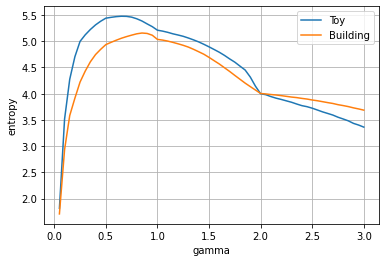

In [4]:
# Read the images and compute the entropy of each images
image_path = ["../images/camera/car/","../images/camera/buildings/"]
gamma = 0.05*np.linspace(1,60,60)
labels = ["Toy", "Building"]
images = [list(),list()]
entropies = [list(),list()]
for i in range(2): # Toy and Building 
    for j in range(1,61):
        img = cv2.imread(os.path.join(image_path[i],str(j)+"image.bmp"))
        images[i].append(img)
        entropies[i].append(entropy(img))
        
# plot the entropy VS gamma relationship for fun
plt.figure()
plt.plot(gamma, np.array(entropies[0]),label=labels[0])
plt.plot(gamma, np.array(entropies[1]),label=labels[1])
plt.xlabel("gamma")
plt.ylabel("entropy")
plt.legend()
plt.grid()
plt.show

In [5]:
def imagewrite(image, string):
    cv2.imwrite("temp.bmp", image)
    os.system("convert temp.bmp " +string) # convert to eps for the manuscript
    os.system("rm temp.bmp")

# Get the desired gamma 
gamma_init = 0.75
# init_index = int(init_gamma/0.05) - 1
label2 = [["a","b","c","d","e","f"],["g","h","i","j","k","l"]]
for i in range(2):
    print("*"*20)
    # read the initial image
    index_init = np.round(gamma_init/0.05).astype(np.int) - 1
    print(labels[i]+ " init:", entropies[i][index_init], gamma[index_init])
    img_init = images[i][index_init]
    imagewrite(img_init, "Fig5_"+label2[i][0]+".eps")
    
    img_init = cv2.cvtColor(img_init, cv2.COLOR_BGR2GRAY)

    
    # get the image with max entropy
    index_max_entr = np.argmax(np.array(entropies[i]))
    print(labels[i]+ "max entropy", entropies[i][index_max_entr], gamma[index_max_entr])
    img_max_entr = images[i][index_max_entr]
    imagewrite(img_max_entr, "Fig5_"+label2[i][1]+".eps")
    
    # BIGC method
    gamma_correct, _ = blind_inverse_gamma_correction(img_init, visual=False)  
    gamma_bigc = gamma_init * gamma_correct
    index_bigc = np.round(gamma_bigc/0.05).astype(np.int) - 1
    index_bigc = np.clip(index_bigc, 0, 59)
    
    print(labels[i]+ " bigc:", entropies[i][index_bigc], gamma[index_bigc])
    img_bigc = images[i][index_bigc]
    imagewrite(img_bigc, "Fig5_"+label2[i][2]+".eps")

    
    # CAB method
    gamma_correct, _ =cab(img_init) 
    gamma_cab = gamma_init * gamma_correct
    index_cab = np.round(gamma_cab/0.05).astype(np.int) - 1
    
    print(labels[i]+ " cab:", entropies[i][index_cab], gamma[index_cab])
    img_cab = images[i][index_cab]
    imagewrite(img_cab, "Fig5_"+label2[i][3]+".eps")
            
    # Test with AGT-ME method
    gamma_correct, _ = adaptive_gamma_transform(img_init, visual=False)  
    gamma_agt = gamma_init * gamma_correct
    index_agt = np.round(gamma_agt/0.05).astype(np.int) - 1
    
    print(labels[i]+ " agt:", entropies[i][index_agt], gamma[index_agt])
    img_agt = images[i][index_agt]
    imagewrite(img_agt, "Fig5_"+label2[i][4]+".eps")
    
     # Test with AGT-ME-VISUAL method
    gamma_correct, _ = adaptive_gamma_transform(img_init, visual=True)  
    gamma_agt_visual = gamma_init * gamma_correct
    index_agt_visual = np.round(gamma_agt_visual/0.05).astype(np.int) - 1
    
    print(labels[i]+ " agt-me-visual:", entropies[i][index_agt_visual], gamma[index_agt_visual])
    img_agt_me = images[i][index_agt_visual]
    imagewrite(img_agt_me, "Fig5_"+label2[i][5]+".eps")
            

********************
Toy init: 5.459554845945166 0.75
Toymax entropy 5.476656053066998 0.65
2.6430517578124997
Toy bigc: 3.9996583425997927 2.0
Toy cab: 5.474435553982605 0.7000000000000001
Toy agt: 5.476656053066998 0.65
Toy agt-me-visual: 5.12216829806675 0.30000000000000004
********************
Building init: 5.1162988708690005 0.75
Buildingmax entropy 5.156802787913433 0.8500000000000001
3.971635742187499
Building bigc: 3.6867429484020593 3.0
Building cab: 5.149018185673942 0.9
Building agt: 5.149018185673942 0.9
Building agt-me-visual: 4.745860677577385 0.4
